In [25]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import networkx as nx

In [ ]:
# website: https://chemantra.tigem.it/index.php?variable=&soglia=0.20
# paper  : https://www.nature.com/articles/s41540-017-0022-3#MOESM13

In [6]:
edges = pd.read_csv('../data/raw/edges.txt', sep='\t')
nodes = pd.read_csv('../data/raw/nodes.txt', sep='\t')

In [7]:
edges.head()

,Var1,Var2,value
0,1,2,0.695147
1,1,3,0.648501
2,2,3,0.621903
3,1,4,0.782713
4,2,4,0.695802


In [8]:
nodes.head()

,idx,Name,Rich Club,Comm
0,1,O-Acetylcholine,51,20
1,2,5-Amino-1-(5-O-phosphonopentofuranosyl)-1H-imi...,274,192
2,3,Allantoin,176,327
3,4,Atabrine,39,64
4,5,O-Carbamimidamidohomoserine,59,113


In [68]:
# how many nodes? 
nnodes = nodes.idx.shape[0]
nnodes

5452

In [69]:
# how many edges? 
nedges = edges.shape[0]
nedges

14859426

In [71]:
# network density? all distances calculated. 
nedges / (0.5*(nnodes**2 - nnodes)) # cuz undirected

1.0

min, max, median, mean: 0.0 1.0 0.6472085594872174 0.6469374915020664
quantiles:
 0.05    0.519584
0.95    0.774310
Name: value, dtype: float64


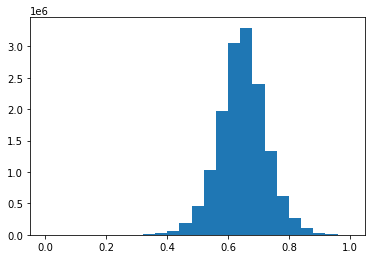

In [35]:
# edge value hist 
print('min, max, median, mean:', edges['value'].min(), edges['value'].max(), edges['value'].median(), edges['value'].mean())
print('quantiles:\n', edges['value'].quantile(q=[0.05, 0.95]))

plt.figure()
plt.hist(edges['value'], bins=25)
plt.show()

In [12]:
# do the names map to lincs cmps? 
lincs_cmp = pd.read_csv('./../../LINCS/LVL3/data/raw/compoundinfo_beta.txt', sep='\t')
lincs_cmp.head()

,pert_id,cmap_name,target,moa,canonical_smiles,inchi_key,compound_aliases
0,BRD-A08715367,L-theanine,NaN,NaN,CCNC(=O)CCC(N)C(O)=O,DATAGRPVKZEWHA-UHFFFAOYSA-N,l-theanine
1,BRD-A12237696,L-citrulline,NaN,NaN,NC(CCCNC(N)=O)C(O)=O,RHGKLRLOHDJJDR-UHFFFAOYSA-N,l-citrulline
2,BRD-A18795974,BRD-A18795974,NaN,NaN,CCCN(CCC)C1CCc2ccc(O)cc2C1,BLYMJBIZMIGWFK-UHFFFAOYSA-N,7-hydroxy-DPAT
3,BRD-A27924917,BRD-A27924917,NaN,NaN,NCC(O)(CS(O)(=O)=O)c1ccc(Cl)cc1,WBSMZVIMANOCNX-UHFFFAOYSA-N,2-hydroxysaclofen
4,BRD-A35931254,BRD-A35931254,NaN,NaN,CN1CCc2cccc-3c2C1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-UHFFFAOYSA-N,r(-)-apomorphine


In [20]:
overlap1 = set(lincs_cmp.cmap_name.unique()).intersection(set(nodes.Name.str.lower().unique()))
overlap2 = set(lincs_cmp.compound_aliases.unique()).intersection(set(nodes.Name.str.lower().unique()))
overlap = overlap1.union(overlap2)
len(overlap)

1274

In [24]:
# kinases
# [x for x in overlap if 'nib' in x]

In [28]:
nodes = nodes.assign(name=lambda x: x.Name.str.lower())
namedict = nodes.set_index('idx')['name'].to_dict()

edges = edges.assign(edge_from= lambda x: x.Var1.map(namedict), edge_to=lambda x: x.Var2.map(namedict))
edges.head()

,Var1,Var2,value,edge_from,edge_to
0,1,2,0.695147,o-acetylcholine,5-amino-1-(5-o-phosphonopentofuranosyl)-1h-imi...
1,1,3,0.648501,o-acetylcholine,allantoin
2,2,3,0.621903,5-amino-1-(5-o-phosphonopentofuranosyl)-1h-imi...,allantoin
3,1,4,0.782713,o-acetylcholine,atabrine
4,2,4,0.695802,5-amino-1-(5-o-phosphonopentofuranosyl)-1h-imi...,atabrine


# edges: 742972
network density: 0.05000004710814536


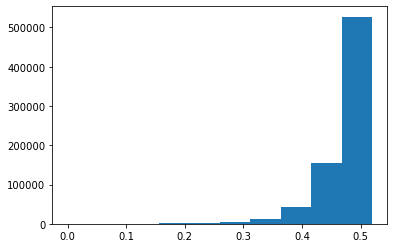

In [95]:
# filter to only include edges if they are less than the n% most similar
q = 0.05

edges2 = edges[lambda x: x['value'] < edges['value'].quantile(q)]
edges2 = edges2.assign(edge_prob = lambda x: 1 - x['value'])

print('# edges:', edges2.shape[0])
print('network density:', edges2.shape[0] / (0.5*(nnodes**2 - nnodes)))

plt.figure()
plt.hist(edges2['value'])
plt.show()

In [96]:
edges2.head()

,Var1,Var2,value,edge_from,edge_to,edge_prob
12,3,6,0.460217,allantoin,salicylic acid,0.539783
26,6,8,0.488779,salicylic acid,bupropion,0.511221
33,6,9,0.290935,salicylic acid,guaiacol,0.709065
57,3,12,0.504132,allantoin,dopamine,0.495868
60,6,12,0.436891,salicylic acid,dopamine,0.563109


In [97]:
G = nx.from_pandas_edgelist(edges2,  source='edge_from', target='edge_to', edge_attr='edge_prob')

print('# nodes:', len(G))
print('# edges:', len(G.edges()))

# nodes: 5164
# edges: 725494


In [98]:
comps = list(nx.connected_components(G))

print('# components: ', len(comps))
_ = [print(f'\t comp: {i} : {len(comps[i])}') for i in range(len(comps))]

# components:  8
	 comp: 0 : 5151
	 comp: 1 : 2
	 comp: 2 : 2
	 comp: 3 : 2
	 comp: 4 : 2
	 comp: 5 : 2
	 comp: 6 : 1
	 comp: 7 : 2


In [99]:
# if we select just the drugs that overlap in cmap, is that a connected component? 
toremove = G.nodes() - overlap
_ = [G.remove_node(node) for node in toremove]

In [100]:
comps = list(nx.connected_components(G))

print('# components: ', len(comps))
_ = [print(f'\t comp: {i} : {len(comps[i])}') for i in range(len(comps))]

# components:  31
	 comp: 0 : 1222
	 comp: 1 : 1
	 comp: 2 : 1
	 comp: 3 : 1
	 comp: 4 : 1
	 comp: 5 : 1
	 comp: 6 : 1
	 comp: 7 : 1
	 comp: 8 : 1
	 comp: 9 : 1
	 comp: 10 : 1
	 comp: 11 : 1
	 comp: 12 : 1
	 comp: 13 : 1
	 comp: 14 : 1
	 comp: 15 : 1
	 comp: 16 : 1
	 comp: 17 : 1
	 comp: 18 : 1
	 comp: 19 : 1
	 comp: 20 : 1
	 comp: 21 : 1
	 comp: 22 : 1
	 comp: 23 : 1
	 comp: 24 : 1
	 comp: 25 : 1
	 comp: 26 : 1
	 comp: 27 : 1
	 comp: 28 : 1
	 comp: 29 : 1
	 comp: 30 : 1


In [101]:
nx.density(G)

0.0513442281318715